#### Multi-Agent Systems
For more complex applications, LangGraph supports multi-agent workflows where different agents handle specific tasks. Here's how to build a multi-agent system with a router agent directing queries to the appropriate expert agents.

In [18]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage, AIMessage, trim_messages
from langchain_core.tools import tool, ToolException, InjectedToolArg
from langchain_core.runnables import RunnableConfig
from langchain_community.utilities import ArxivAPIWrapper
from langchain_community.tools import ArxivQueryRun, HumanInputRun
from langgraph.graph import StateGraph, START, END, add_messages, MessagesState
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.base import BaseStore
from langgraph.store.memory import InMemoryStore
from typing import Annotated, Optional
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
from langchain_google_vertexai import ChatVertexAI
import wikipedia
import uuid
import operator
from IPython.display import Image, display
import os

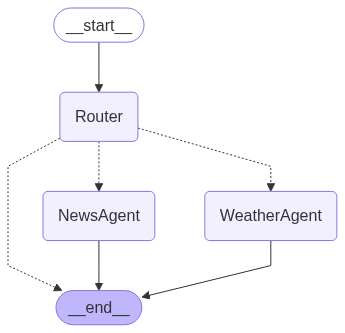

=== Weather Query ===

=== News Query ===
'NewsAgent': Here are the latest news headlines...

=== General Query ===


In [23]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

# Create agents for routing, news and weather. The router agent directs queries to the appropriate agent based on the user's input.
# def router_agent(state: State):
#     """Router agent that doesn't add messages, just used for routing logic"""
#     return {"messages": []}

# OR we can also use LLM for more advanced routing
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "/Users/mncedisimncwabe/Downloads/hallowed-span-459710-s1-c41d79c9b56b.json"
def router_agent(state: State):
    """Router agent that uses LLM to determine routing"""
    llm = ChatVertexAI(
            model_name="gemini-2.0-flash-001",
            temperature=0, 
            max_output_tokens=2048, 
            project= "hallowed-span-459710-s1" ,
            location= "us-central1"  
        )
    
    system_msg = SystemMessage(content="""You are a routing agent. Based on the user's message, determine if they want:
    - weather: for weather-related queries
    - news: for news-related queries  
    - general: for anything else
    
    Respond with only one word: weather, news, or general""")
    
    messages = [system_msg, state['messages'][-1]]
    response = llm.invoke(messages)
    
    # Don't add routing decision to messages, just return empty
    return {"messages": []}

def weather_agent(state: State):
    """Weather agent that returns weather information"""
    weather_response = AIMessage(content="The weather is sunny today!")
    return {"messages": [weather_response]}

def news_agent(state: State):
    """News agent that returns news information"""
    news_response = AIMessage(content="Here are the latest news headlines...")
    return {"messages": [news_response]}

def route_logic(state: State):
    """Function to determine routing based on user input"""
    user_input = state['messages'][-1].content.lower()
    if "weather" in user_input:
        return "WeatherAgent"
    elif "news" in user_input:
        return "NewsAgent"
    else:
        return END

# Set up the workflow by adding nodes and defining conditional paths based on the router's decisions.
graph_builder = StateGraph(State)
graph_builder.add_node("Router", router_agent)
graph_builder.add_node("WeatherAgent", weather_agent)
graph_builder.add_node("NewsAgent", news_agent)

# Start with the router, Add conditional routing from Router
graph_builder.add_edge(START, "Router")
graph_builder.add_conditional_edges(
    source="Router",
    path=route_logic,
    path_map={
        "WeatherAgent": "WeatherAgent",
        "NewsAgent": "NewsAgent",
        END: END
    }
)

graph_builder.add_edge("WeatherAgent", END)
graph_builder.add_edge("NewsAgent", END)
graph = graph_builder.compile()

# View the graph
display(Image(graph.get_graph().draw_mermaid_png()))

# Test the graph
inputs = {"messages": [HumanMessage(content="What's happening in South Africa with VAT")]}
print("=== Weather Query ===")
for output in graph.stream(inputs):
    for key, value in output.items():
        if value.get('messages') and len(value['messages']) > 0:
            print(f"'{key}': {value['messages'][-1].content}")

print("\n=== News Query ===")
inputs_news = {"messages": [HumanMessage(content="Give me the latest news.")]}
for output in graph.stream(inputs_news):
    for key, value in output.items():
        if value.get('messages') and len(value['messages']) > 0:
            print(f"'{key}': {value['messages'][-1].content}")

print("\n=== General Query ===")
inputs_general = {"messages": [HumanMessage(content="Hello, how are you?")]}
for output in graph.stream(inputs_general):
    for key, value in output.items():
        if value.get('messages') and len(value['messages']) > 0:
            print(f"'{key}': {value['messages'][-1].content}")